# CSII 2024 Exercise 02: State Feedback for CS2 Bot Steering
&copy; 2024 ETH Zurich, Joël Gmür, Moritz Heppler, Ivan Robuschi, Stephan König, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Reference: 
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for CS2 bot Steering
The dynamics of the CS2 Bot are given by a simple unicycle model which was first presented in the introductory notebook 2. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the CS2 Bot in the plane and $\theta$ is the angle of the CS2 Bot with respect to the x-axis. The input of the CS2 Bot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed.

Note: We use absolute coordinates in global frame $(x, y, \theta)$ for our states and not coordinates relative to our reference line as shown in the figure $(d,\theta)$. 

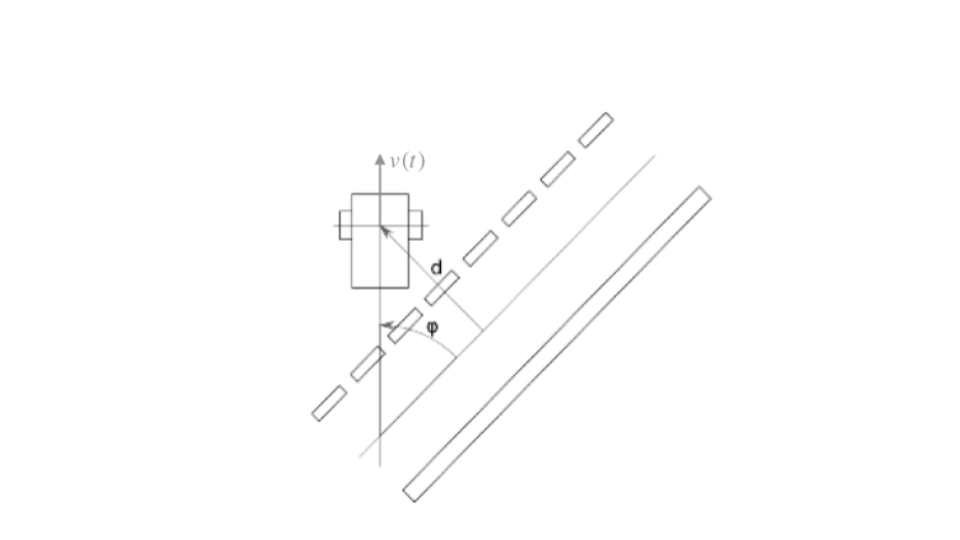

Let's start by installing the `control` module.




In [ ]:
# Install the required python library with pip 
%pip install cs2solutions --force-reinstall

------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, take a look at the documentation and some tutorials. It is very important for matrix operations in Python.



In [ ]:
# Import the required python libraries
from typing import Optional, List
from cs2solutions import duckiebot, lqrfeedback
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the CS2 Bot are defined in the next cell.
$v$ is the velocity of the CS2 Bot. This variable is stored in u[0].
The angular velocity $\omega$ is stored in u[1].
The array $x$ contains the x-position of the CS2 Bot at x[0],
the y-position at x[1], and the angle with respect to the x-axis $\theta$ at x[2].
These three values form the state of the system.

As you can see in the update function, the system is nonlinear in $\theta$ and thus will need to be linearized later on.

Note: This is the model we created in Introductory Notebook 2. We have put the update functions into the package ``cs2solutions.duckiebot``.
If you are interested, you can inspect the various functions or access them on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/duckiebot.py#L1-L171)

## Parameters and Reference Track

We set a default CS2 Bot forward velocity and initiate the nonlinear system using the `control` library. For more info, see the [documentation](https://python-control.readthedocs.io/en/latest/intro.html).

In [ ]:
# Default CS2 Bot velocity in m/s
bot_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the CS2 Bot's steering dynamics as an input/output system
bot = ct.NonlinearIOSystem(
    duckiebot.unicycle_update, duckiebot.unicycle_output, states=3, name='bot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=bot_params)

v0 = bot_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angular velocity `w_curvy`. 

In [ ]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard']
curve_difficulty = curve_difficulty_levels[0]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.05*np.sin(T_curvy*np.pi/10)
elif curve_difficulty=='hard':
    w_curvy = 0.025*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    bot, T_curvy, u_curvy, X0_curvy, params=bot_params, return_x=True)

duckiebot.plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [ ]:
# Define the lateral dynamics as a subset of the full CS2 Bot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: duckiebot.unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: duckiebot.unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=bot_params)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C
D = lateral_linearized.D
print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)

The state space description of the linearized system reads  
$$\begin{bmatrix}\dot{y} \\ \dot{\theta} \end{bmatrix} = \begin{bmatrix}0 & 0.1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} y \\ \theta \end{bmatrix} + \begin{bmatrix}0 \\ 1 \end{bmatrix} \omega, $$  

$$y = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} y \\ \theta \end{bmatrix} . $$


## State Feedback Control




Having reduced our model to just the lateral dynamics of the CS2 Bot, we want to introduce a state feedback controller that can track a lateral position reference. By neglecting the longitudinal dynamics (assuming constant forward velocity) and linearizing about the operating point, we have obtained a SISO LTI system, where the state is given by $x = \begin{bmatrix} y & \theta \end{bmatrix}^\mathsf{T}$, the input is $u = \omega$, and the output is $y = y$, the lateral distance from the origin. 

Consider the state feedback controller $u = -Kx + k_r r$, where $K \in \mathbb{R}^{2 \times 1}$ is the state feedback gain matrix and $k_r$ is the feedforward gain. For zero steady state error, we choose $k_r = -\frac{1}{C(A-BK)^{-1}B}$. The dynamics of the closed loop system are then given by $$\dot{x} = (A - BK)x + Bk_r r = A_{cl}x + Bk_r r,$$ where $A_{cl} = A - BK $ is also called the closed loop state transition matrix. We can see that the stability of our system must now depend only on the eigenvalues of $A_{cl}$.




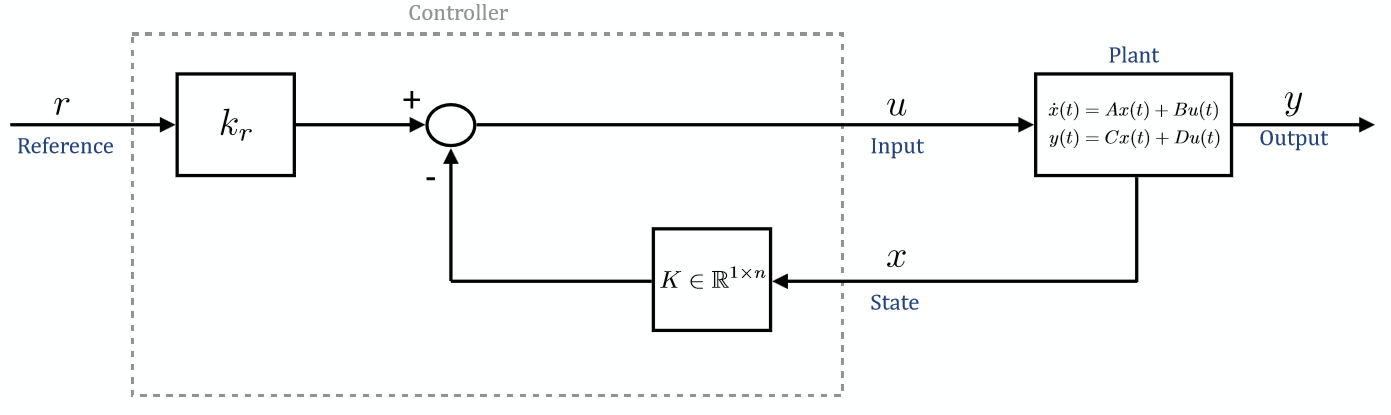


### Step Response with various $K$

First, we will try out some given values for $K$ and look at the system response to a unit step reference. For this purpose, we define a new system with the closed loop dynamics stated in the cell above. We then simulate a step input and plot the output $d$, the reference $d_{ref}$ as well as the input $\omega$. 

To begin, let's try out a gain matrix of $K = \begin{bmatrix} 1.2 & 0.7\end{bmatrix}$.

In [ ]:
K1 = np.array([[1.2, 0.7]])
A_cl1 = A - B @ K1
assert np.linalg.det(A_cl1) != 0, "A - BK is not invertible"
k_r1 = -1/(C @ np.linalg.inv(A_cl1) @ B)
B_cl1 = B * k_r1
syscl1 = ct.ss(A_cl1, B_cl1, C, D)
# Compute the step response
t, y, x = ct.step_response(syscl1, np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K1 @ x + k_r1 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
duckiebot.plot_step_response(t, y, u)
plt.tight_layout()

Next, let's try out a gain matrix of $K = \begin{bmatrix} 32.5 & 0.2\end{bmatrix}$.

In [ ]:
K2 = np.array([[32.5, 0.2]])
A_cl2 = A - B @ K2
assert np.linalg.det(A_cl2) != 0, "A - BK is not invertible"
k_r2 = -1/(C @ np.linalg.inv(A_cl2) @ B)
B_cl2 = B * k_r2
syscl2 = ct.ss(A_cl2, B_cl2, C, D)
# Compute the step response
t, y, x = ct.step_response(syscl2, np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K2 @ x + k_r2 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
duckiebot.plot_step_response(t, y, u)
plt.tight_layout()


Lastly, let's look at the step response given the gain matrix $K = \begin{bmatrix} 32.5 & -0.2\end{bmatrix}$.

In [ ]:
K3 = np.array([[32.5, -0.2]])
A_cl3 = A - B @ K3
assert np.linalg.det(A_cl3) != 0, "A - BK is not invertible"
k_r3 = -1/(C @ np.linalg.inv(A_cl3) @ B)
B_cl3 = B * k_r3
syscl3 = ct.ss(A_cl3, B_cl3, C, D)
# Compute the step response
t, y, x = ct.step_response(syscl3, np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K3 @ x + k_r3 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
duckiebot.plot_step_response(t, y, u)
plt.tight_layout()


### Exercise 1: Calculate Poles
Your first task is to calculate the poles of the closed loop system (``A_cl1``, ``A_cl2``, ``A_cl3``). Do they match your expectation after looking at the step responses? You may use the imported library numpy.

Hint: You may use variables defined in the last three code cells.

In [ ]:
# TODO Calculate the poles of the closed-loop system for feedback gains K1, K2, and K3

### Exercise 1: Solution
The poles of the closed loop system are the eigenvalues of the closed loop dynamics matrix $A_{cl} = A - BK$. These are easily obtained using the library function np.linalg.eigvals.
The obtained values should align with our intuition from control systems I. If we have real poles with negative real part, the output converges to the reference without any overshoot. If the poles have negative real part, but nonzero imaginary part, the output still converges to the reference, but oscillates. If the poles have positive real part, the output diverges.

In [ ]:
# Calculate the poles of the closed-loop system for feedback gains K1, K2, and K3
lqrfeedback.sol_print_poles(A_cl1, A_cl2, A_cl3)

You can access the solution by right-clicking and going to the definition of ``lqrfeedback.sol_print_poles()`` or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/lqrfeedback.py#L16-L48).

# State Feedback Gain Matrix and the Ackermann Formula
To find appropriate values for the state feedback gain matrix K, we can make use of the Ackermann formula
  
$$\mathbf{K} = [0\;...\;0\;1]\mathcal{R}^{-1}p_{cl}^{*}(A) = \gamma p_{cl}^{*}(A).$$
  
Where $\mathcal{R}$ is the Reachability Matrix of the system and $\gamma$ is the last row of the inverse of $\mathcal{R}$. The first step is the calculate the Reachability Matrix with the formula
  
$$\mathcal{R} = [\;B\;AB\;...\;A^{n-1}B].$$

### Exercise 2
Calculate the $\mathcal{R}$ matrix using a for-loop. You can either do it for two dimensions or try and implement the code for the general case.  
You may use the imported library numpy.

In [ ]:
def control_matrix(A: np.array, B: np.array) -> np.array:
    """
    Create the controllability matrix R of a system given the state-space representation.
    Variation 1.

    Parameters:
    - ``A`` (np.array): The state matrix.
    - ``B`` (np.array): The input matrix.

    Returns:
    - ``R```(np.array): Controllability matrix.
    """
    # TODO Calculate the control matrix
    R = 0
    return R

control_matrix(A, B)

### Exercise 2: Solution


In [ ]:
# Two possible solution implementations are listed below
R = lqrfeedback.sol_control_matrix1(A, B)
R_2 = lqrfeedback.sol_control_matrix2(A, B)
print(R)
print(R_2)

You can access the solution by right-clicking and going to the definition of ``lqrfeedback.sol_control_matrix1()`` or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/lqrfeedback.py#L51-L113).

### Exercise 3
Try and think of good values for the poles $s_1$ and $s_2$ and extract the coefficients of the resulting characteristic polynomial. For example, if we choose the poles at $s_1 = -1$ and $s_2 = -2$ the characteristic polynomial reads $p_{cl}^{*}(s) = s^2+3s + 2$ from which we see $a_0^{*} = 3, \;a_1^{*} = 2.$  

Choose some values for your poles, then implement the Ackermann formula to calculate the state feedback gain matrix $K$. Next, compute the state-space matrices of the closed loop.  
You may use the imported library numpy.

More specifically:
- Use the two poles to determine the characteristic polynomial
- Determine K using the Ackermann formula and the characteristic polynomial
- Determine A_cl and B_cl using K
- Determine k_r. The formula has already appeared in this notebook c:

In [ ]:
# TODO Choose the values for the poles and construct the array "poles" 
p_1 = -1
p_2 = -2
poles = None
# TODO Calculate the closed loop characteristic polynomial coefficients a_0 and a_1
a_0, a_1 = None, None
# TODO Evaluate the Ackermann formula 
K = None
print(K)

# TODO Compute the state-space matrices of the closed loop system, which takes r as an input
A_cl = None
k_r = None
B_cl = None


### Exercise 3: Solution

In [ ]:
p_cl, K, k_r, A_cl, B_cl = lqrfeedback.sol_2x2_ackermann(A, B, C, p_1, p_2)

You can access the solution by right-clicking and going to the definition of ``lqrfeedback.sol_2x2_ackermann()`` or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/lqrfeedback.py#L116-L169).

The following code section visualizes tracking of a step reference using the just calculated state feedback gain matrix $\mathbf{K}$.
After implementing state feedback, our system now reads
$$ \dot{x}(t) = (A-BK)x(t) + Bk_r r(t) . $$ 

In [ ]:
# Implement state feedback
syscl = ct.ss(A_cl, B_cl, C, D)
print(np.linalg.eigvals(A_cl))

# Compute the step response
t, y, x= ct.step_response(syscl, T=np.linspace(0, 20, 100), return_x=True)

# Compute the input used to generate the control response (check lecture slides)
u = -K @ x + k_r * 1

# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])

# Plot the results
duckiebot.plot_step_response(t, y, u)
plt.tight_layout()
plt.show()

### Reference Tracking with State Feedback

In the lecture you found out that, if an LTI system is reachable, a state feedback controller can place the closed loop poles at arbitrary locations. Let's examine the tracking performance of some example controllers using the more complicated reference generated in the beginning of the notebook. We will look at two controllers, a rather aggressive, slightly underdamped one with poles at $s = -0.7 \pm 3j$ as well as a slower, overdamped one with poles at $s = -1, -1.5$ .

In [ ]:
# Define reference values & initial conditions
x_ref = x_curvy[0]
y_ref = x_curvy[1]
theta_ref = x_curvy[2]
omega_ref = w_curvy
t = T_curvy
x_0 = [0.2, 0]

# Place poles according to problem description and generate 2 LTI systems
p_fast = np.array([-0.7 + 3j, -0.7 - 3j])
p_slow = np.array([-1.5, -1])
K_fast = ct.acker(A, B, p_fast)
K_slow = ct.acker(A, B, p_slow)

A_cl_fast = A - B @ K_fast
k_r_fast = -1/(C @ np.linalg.inv(A_cl_fast) @ B)
B_cl_fast = B * k_r_fast

A_cl_slow = A - B @ K_slow
k_r_slow = -1/(C @ np.linalg.inv(A_cl_slow) @ B)
B_cl_slow = B * k_r_slow

# Construct the system with the closed loop matrices
sys_fast = ct.ss(A_cl_fast, B_cl_fast, C, D)
sys_slow = ct.ss(A_cl_slow, B_cl_slow, C, D)

# Simulate the system response to the reference input
t, yf, xf = ct.forced_response(sys_fast, T_curvy, y_ref, X0 = x_0, return_x=True)
omegaf = - K_fast @ xf + k_r_fast * y_ref
t, ys, xs = ct.forced_response(sys_slow, T_curvy, y_ref, X0 = x_0, return_x=True)
omegas = -K_slow @ xs + k_r_slow * y_ref

# Plot the results
y = np.array([yf, ys])
omega = np.array([omegaf[0], omegas[0]])

duckiebot.plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega, ['Fast', 'Slow'])

As you can see, the aggressive controller captures the reference much quicker and stays closer to it afterwards. The oscillations could even be reduced by placing the poles closer to the real axis. Why don't we just place our poles at $-\infty$? The answer can be found looking at the plot for $\omega$. You can see that the aggressive controller, starting from the same initial condition, commands a control action about 6 times higher in magnitude than the slower controller. Even if the physical system can follow this input, it is energetically much more expensive than the slow controller solution. More often, the control actuators on a real system can only follow an input up to a certain magnitude until saturating, resulting in much degraded system performance compared to the simulation that isn't affected by input saturation.

Thus, there is some sort of tradeoff between control performance and expended input energy. One way to design a controller that takes this into account when choosing control action is to quantify the tradeoff in a cost function. The resulting control problem is solved by the $\textbf{Linear Quadratic Regulator}.$


# Cost Function and the Linear Quadratic Regulator


In order to solve this problem, we define a cost function
$$J = \int_0^{\infty}u^TRu + x^TQx + 2x^TNu \;dt .$$   
where $u$ is the input of the system, $x$ is the state of the system and $R, Q, N$ are the weight matrices. Our goal is to find a controller that minimizes the cost function $J$. Such a controller is called optimal. We choose the entries of the weighting matrices according to what we want to "punish" more, bad performance or high energy expenditure.  
Most of the time we assume the interactive matrix $N$ to be zero. The matrices $R$ and $Q$ need to be symmetric and positive definite. Notice that the first two terms are quadratic forms in $u$ and $x$ respectively. Intuitively, given $N = 0$, you can think of $J$ as the square of the norm of $u$ and $x$, summed up over all $t$. The weight matrices allow us to weigh certain states (and, in the MIMO case, also inputs - where MIMO stands for "Multiple Input Multiple Output", as seen later in this course) differently from others. Provided some conditions on controllability and observability are fulfilled, there exists a stabilizing controller that minimizes the given cost function for any initial condition. This controller always takes the form $u = -K_{LQR}x$, i.e. it is a state feedback controller with constant gain. This is somewhat surprising, as we made no assumptions on the controller structure beforehand. Also note that this is framed as a regulator problem, i.e. the control objective is to drive the state to the origin from some nonzero initial condition. This might seem restrictive, but a reference tracking problem can be rephrased in this way without too much effort.

### Exercise 4
Write a function that checks whether the some R and Q are symmetric and positive definite. The output should be a boolean value. You can check if your function works with the given matrices.  
You may use the imported library numpy.

In [ ]:
# TODO Function named "check_pos_def_sym" that checks if the matrix is symmetric and positive definite
def check_pos_def_sym(A: np.ndarray) -> bool:
    """
    Check if the given matrix is symmetric and positive definite.

    Parameters:
    - ``A`` (np.array): The matrix to be checked.

    Returns:
    - ``bool``: True if the matrix is symmetric and positive definite, False otherwise.
    """
    # TODO Implement the function
    return False

### Exercise 4: Solution

In [ ]:
lqrfeedback.test_check_pos_def_sym(check_pos_def_sym, lqrfeedback.sol_check_pos_def_sym)

You can access the solution by right-clicking and going to the definition of ``lqrfeedback.sol_check_pos_def_sym()`` or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/lqrfeedback.py#L172-L195).

### Algebraic Riccati Equation
Now that we can check that our matrices have the necessary properties, we can try to find the input $u(t) = -K_{LQR}x(t)$ that minimizes the cost function. The optimal solution is given by the Continuous-Time Algebraic Riccati Equation
$$A^TP + PA - (N + PB)R^{-1}(N^T + B^TP) + Q = 0 .$$
Once we have found $P$ we can determine the optimal state feedback gain matrix with   
$$K_{LQR} = R^{-1}(N + PB)^T .$$  


### Exercise 5
Write a function that calculates P through the Algebraic Riccati Equation and determine the state feedback gain matrix $K_{LQR}$. The function should also check if $Q$ and $R$ are symmetric and positive definite using your solution from Exercise 4.  
The output should be a numpy array or an error message.  
You may use numpy and the function ct.care(A, B, Q, R)[0] to calculate P.

Hint: Use $P=\begin{pmatrix}
7 & 8 \\
8 & 10
\end{pmatrix}$ and $R=11$.

In [ ]:
# TODO Define the weighting matrices Q and R
Q = None
R = None

# TODO Define the function "K_LQR" that returns the optimal gain 
def K_LQR(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    """
    Calculate the optimal gain for the LQR problem.

    Parameters:
    - ``A`` (np.ndarray): The state matrix.
    - ``B`` (np.ndarray): The input matrix.
    - ``Q`` (np.ndarray): The state weighting matrix.
    - ``R`` (np.ndarray): The input weighting matrix.

    Returns:
    - ``K```(np.ndarray): The optimal gain.
    """
    # TODO Implement the function
    return None

### Exercise 5: Solution

In [ ]:
# Define the weighting matrices Q and R
Q = np.array([[7, 8], [8, 10]])
R = np.array([[11]])
print(lqrfeedback.sol_K_LQR(A, B, Q, R))

You can access the solution by right-clicking and going to the definition of ``lqrfeedback.sol_K_LQR()`` or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/lqrfeedback.py#L238-L264).

### LQR Step Response
The next section visualizes the step response of the LQR controller for different weight matrices. The weights are categorized as "cheap" or "expensive". This is because we call a control action "cheap", when we assign it a low weight and thus punish it less strongly compared to the state deviation and vice versa for "expensive". 

In [ ]:
# Define weighting matrices
Q1 = np.array([[20, 0], [0, 0.01]]) #Cheap control
R1 = np.array([[0.01]])

Q2 = np.array([[7, 0], [0, 0.01]]) #Expensive control
R2 = np.array([[100]])

Q3 = np.array([[20, 0], [0, 0.1]]) #In-between control
R3 = np.array([[2]])

# Calculate state feedback gains
# Make sure to have implemented 'K_LQR', otherwise you may use the solution 'lqrfeedback.sol_K_LQR'
K_LQR_1 = K_LQR(A, B, Q1, R1)
K_LQR_2 = K_LQR(A, B, Q2, R2)
K_LQR_3 = K_LQR(A, B, Q3, R3)

# Calculate the feedforward gains and closed loop system matrices
A_cl_1 = A - B @ K_LQR_1
A_cl_2 = A - B @ K_LQR_2
A_cl_3 = A - B @ K_LQR_3

k_r_1 = -1/(C @ np.linalg.inv(A_cl_1) @ B)
k_r_2 = -1/(C @ np.linalg.inv(A_cl_2) @ B)
k_r_3 = -1/(C @ np.linalg.inv(A_cl_3) @ B) 

B_cl_1 = B * k_r_1
B_cl_2 = B * k_r_2
B_cl_3 = B * k_r_3

In [ ]:
# Plot the step response
syscl_1 = ct.ss(A_cl_1, B_cl_1, C, D)
syscl_2 = ct.ss(A_cl_2, B_cl_2, C, D)
syscl_3 = ct.ss(A_cl_3, B_cl_3, C, D)

# Compute the step response
t_1, y_1, x_1 = ct.step_response(syscl_1, T=np.linspace(0, 20, 100), return_x=True)
t_2, y_2, x_2= ct.step_response(syscl_2, T=np.linspace(0, 20, 100), return_x=True)
t_3, y_3, x_3= ct.step_response(syscl_3, T=np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u_1 = -K_LQR_1 @ x_1 + k_r_1 * 1
u_2 = -K_LQR_2 @ x_2 + k_r_2 * 1
u_3 = -K_LQR_3 @ x_3 + k_r_3 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
duckiebot.plot_step_response(t_1, y_1, u_1)
duckiebot.plot_step_response(t_2, y_2, u_2)
duckiebot.plot_step_response(t_3, y_3, u_3)
plt.legend(['Cheap control', 'Expensive control', 'In-between control'])
plt.tight_layout()

plt.show()

### Exercise 6: Calculate Poles
As with the first state feedback controller, calculate the poles of the closed loop system. Do they match with the plots above? You may use the imported libraries numpy.

In [ ]:
# TODO Calculate the poles of the closed-loop system for feedback gains K_LQR_1, K_LQR_2, and K_LQR_3

### Exercise 6: Solution

The poles of the closed loop system are the eigenvalues of the closed loop dynamics matrix $A_{cl, i} = A - BK_{LQR, i}$. These are easily obtained using the library function np.linalg.eigvals.
The results should again align with our intuition. The more negative the real part of the poles, the quicker the output converges to the reference.

In [ ]:
# Calculate the poles of the closed-loop system for feedback gains K_LQR_1, K_LQR_2, and K_LQR_3
lqrfeedback.sol_print_poles(A_cl_1, A_cl_2, A_cl_3)

You can access the solution by right-clicking and going to the definition of ``lqrfeedback.sol_print_poles()`` or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/d7ebf91955bf6c06b9f20ec6ed6654c9574777df/src/cs2solutions/lqrfeedback.py#L16-L48).

### Reference Tracking with LQR
Let's now look at how the LQR handles the reference trajectory generated earlier in the notebook.

In [ ]:
# Define reference values & initial conditions
x_ref = x_curvy[0]
y_ref = x_curvy[1]
theta_ref = x_curvy[2]
omega_ref = w_curvy
t = T_curvy

# Simulate the system response to the reference input
t, yL1, xL1 = ct.forced_response(syscl_1, T_curvy, y_ref, X0 = x_0, return_x=True)
omegaL1 = - K_LQR_1 @ xL1 + k_r_1 * y_ref
t, yL2, xL2 = ct.forced_response(syscl_2, T_curvy, y_ref, X0=x_0, return_x=True)
omegaL2 = -K_LQR_2 @ xL2 + k_r_2 * y_ref
t, yL3, xL3 = ct.forced_response(syscl_3, T_curvy, y_ref, X0=x_0, return_x=True)
omegaL3 = -K_LQR_3 @ xL3 + k_r_3 * y_ref
# Plot the results
y = np.array([yL1, yL2, yL3])
omega = np.array([omegaL1[0], omegaL2[0], omegaL3[0]])

duckiebot.plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega, np.array(['Cheap control', 'Expensive control', 'In-between control']))

